2023-05-21 11:24:21.001783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400
2023-05-21 11:24:25.843878: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-21 11:24:25.843924: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-21 11:24:25.873470: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

1/1 [==============================] - 7s 7s/step


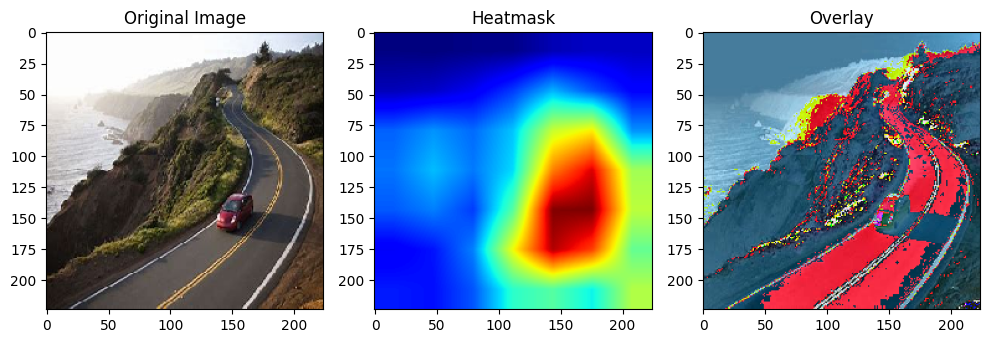

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import cv2

# Load the pretrained ResNet model
resnet_model = tf.keras.applications.ResNet50(include_top=True, weights='imagenet')

# Choose the layer for visualization
layer_name = 'conv5_block3_out'
selected_layer = resnet_model.get_layer(layer_name)

# Create a new model that outputs the selected layer's activations
heatmap_model = tf.keras.models.Model(inputs=resnet_model.input, outputs=selected_layer.output)

# Preprocess the image
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img

# Load and preprocess the image
image_path = 'highway.jpeg'
img = image.load_img(image_path, target_size=(224, 224))
image = preprocess_image(image_path)

# Get the activations of the selected layer
activations = heatmap_model.predict(image)

# Resize the activations to the size of the original image
resized_activations = tf.image.resize(activations, (image.shape[1], image.shape[2]))

# Convert the activations to grayscale
grayscale_activations = np.mean(resized_activations, axis=-1)

# Normalize the grayscale activations
normalized_activations = (grayscale_activations - np.min(grayscale_activations)) / (np.max(grayscale_activations) - np.min(grayscale_activations))

# Apply the colormap (jet) to create a heatmask
heatmask = plt.cm.jet(normalized_activations)[..., :3]  # Keep only the RGB channels

# Overlay the heatmask on the original image
overlay = (image[0] + heatmask * 0.5).clip(0, 1)  # Adjust the blending factor as needed
overlay = overlay[0]
normalized_activations = normalized_activations[0]
# Plot the original image, heatmask, and overlay
cmap = plt.colormaps.get_cmap('jet')  # Choose the desired colormap
heatmask_rgb = cmap(normalized_activations)[..., :3]  #

plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(132)
plt.imshow(heatmask_rgb)
plt.title('Heatmask')
plt.subplot(133)

heatmask_rgb = heatmask_rgb.astype(np.float32)

# Rescale the values in heatmask_rgb to be between 0 and 1
heatmask_rgb /= 255.0

# Scale the heatmask_rgb with the input image using alpha blending
alpha = 0.000000002  # Adjust the alpha value as desired
overlay = cv2.addWeighted(image[0].astype(np.float32), 1 - alpha, heatmask_rgb, alpha, 0.8)

# Convert the overlay back to uint8 format
overlay = (overlay * 255).astype(np.uint8)

plt.imshow(overlay)
plt.title('Overlay')
plt.tight_layout()
plt.show()
